In [1]:
import os
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json

print(os.path.exists("cube.obj")) 

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!
True


In [2]:
mi.set_variant('scalar_rgb')

def light_grid(face, n1, n2, const_val):
    positions = []
    if face == "top":
        xs = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for x in xs:
            for z in zs:
                positions.append((face, [x, const_val, z]))
    elif face == "back":
        xs = np.linspace(-4, 4, n1)
        ys = np.linspace(-4, 4, n2)
        for x in xs:
            for y in ys:
                positions.append((face, [x, y, const_val]))
    elif face == "left" or face == "right":
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append((face, [const_val, y, z]))

    return positions


def get_light_color(face, config_name):
    with open('color_configs.json') as f:
        color_configs = json.load(f)

    if config_name not in color_configs:
        raise ValueError(f"Configuration '{config_name}' not found in color_configs.json")
    config = color_configs[config_name]

    color = config.get(face, [0, 0, 0])

    return color

configs = json.load(open("color_configs.json"))
print(configs.keys())


dict_keys(['RGB', 'CMYK', 'GRAY', 'WHITE', 'WARM', 'COOL', 'RAINBOW', 'NEON', 'PASTEL', 'SIDES', 'TOP'])


In [3]:
# 10 x 15 = 150 lights per face
top_pos   = light_grid("top",   10, 15,  4.5)   
back_pos  = light_grid("back",  10, 15, -4.5)  
left_pos  = light_grid("left",  10, 15, -4.5)  
right_pos = light_grid("right", 10, 15,  4.5)   

all_pos = top_pos + back_pos + left_pos + right_pos

In [4]:
num_emitters = len(all_pos)
print(f"Number of emitters: {num_emitters}")
emitters = {}

CONFIG = "RGB"

for i, (face, pos) in enumerate(all_pos):
    color = get_light_color(face, CONFIG)
    emitters[f"light_{i}"] = {
        "type": "point",
        "position": pos,
        "intensity": {
            "type": "rgb",
            "value": color
        }
    }

Number of emitters: 600


In [5]:
for key, val in emitters['light_0'].items():
    print( f"{key}: {val}")

def update_emitters(emitters, translation, scale, orientation):
    x, y, z = translation
    s = scale
    x_r, y_r, z_r = orientation

    transform = (
        mi.ScalarTransform4f()
        .translate([x, y, z])
        .rotate([1, 0, 0], x_r)
        .rotate([0, 1, 0], y_r)
        .rotate([0, 0, 1], z_r)
        .scale(s)
    )

    # for light in emitters.values():
    #     orig_pos = light["position"]
    #     new_pos = transform @ mi.Point3f(orig_pos)
    #     light["position"] = new_pos

    # return

    updated_emitters = {}

    for name, light in emitters.items():
        orig_pos = light["position"]
        # Apply transformation to the position
        new_pos = transform @ mi.Point3f(orig_pos)

        # Reassign updated light with transformed position
        updated_emitters[name] = {
            **light,  # copy other properties
            "position": new_pos
        }

    return updated_emitters





type: point
position: [np.float64(-4.0), 4.5, np.float64(-4.0)]
intensity: {'type': 'rgb', 'value': [1.0, 1.0, 1.0]}


In [6]:
def render_scene(emitters, config="RGB", save_path=None):
    scene_dict = {
        "type": "scene",
        "integrator": {"type": "path"},
        "sensor": {
            "type": "perspective",
            "sampler": {"type": "independent", "sample_count": 512},
            "to_world": mi.ScalarTransform4f().look_at(
                origin=[0, -2, 19], target=[0, -5, 0], up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "width": 800,
                "height": 600,
                "pixel_format": "rgb"
            },
        },
        "env": {
            "type": "constant",
            "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
        },
        "checkerboard": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f()
                .translate([0, -5, 0])
                .rotate([1, 0, 0], -90)
                .scale([8, 8, 1]),
            "bsdf": {
                "type": "diffuse",
                "reflectance": {
                    "type": "checkerboard",
                    "color0": {"type": "rgb", "value": [1.0, 1.0, 1.0]},
                    "color1": {"type": "rgb", "value": [0.0, 0.0, 0.0]},
                    "to_uv": mi.Transform4f().scale(mi.Vector3f(10, 10, 1))
                }
            }
        }
    }

    scene_dict.update(emitters)

    scene = mi.load_dict(scene_dict)
    img = mi.render(scene)
    bitmap = mi.util.convert_to_bitmap(img)

    if save_path:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.show()


ORIGINAL:


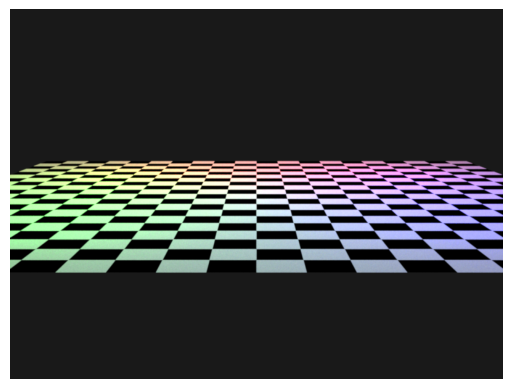


No translation, same scale, rotated 90 degrees around y-axis


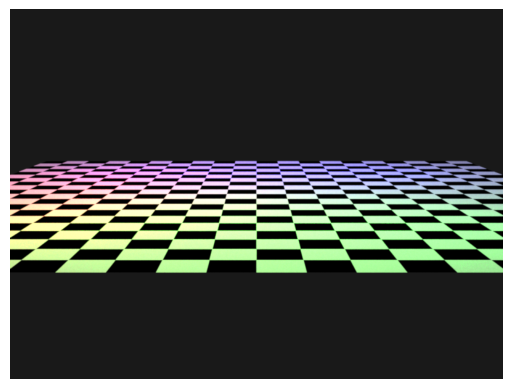


No translation, 3x scale, rotated 180 degrees around y-axis


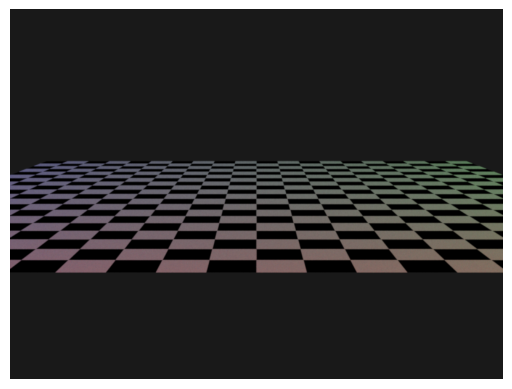


Translate 10 units right, same scale, no rotation


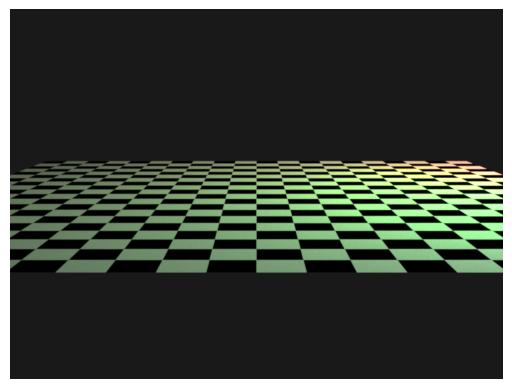

In [12]:
print("ORIGINAL:")
render_scene(emitters, config=CONFIG, save_path="output/transform.png")

print("\nNo translation, same scale, rotated 90 degrees around y-axis")
e1 = update_emitters(emitters, [0, 0, 0], 1, [0, 90, 0])
render_scene(e1, config=CONFIG, save_path="output/transform2.png")

print("\nNo translation, 3x scale, rotated 180 degrees around y-axis")
e2 = update_emitters(emitters, [0, 0, 0], 3, [0, 180, 0])
render_scene(e2, config=CONFIG, save_path="output/transform3.png")

print("\nTranslate 10 units right, same scale, no rotation")
e3 = update_emitters(emitters, [10, 0, 0], 1, [0, 0, 0])
render_scene(e3, config=CONFIG, save_path="output/transform4.png")



No translation, same scale, rotated 90 degrees around z-axis


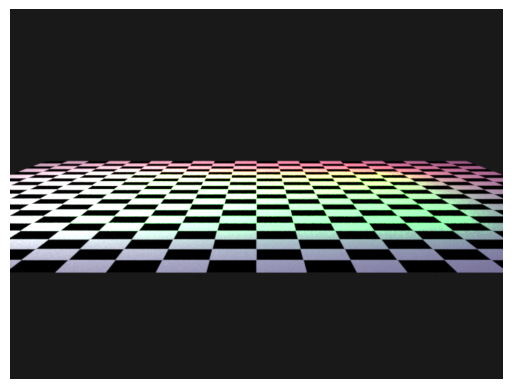


No translation, same scale, rotated 90 degrees around x-axis


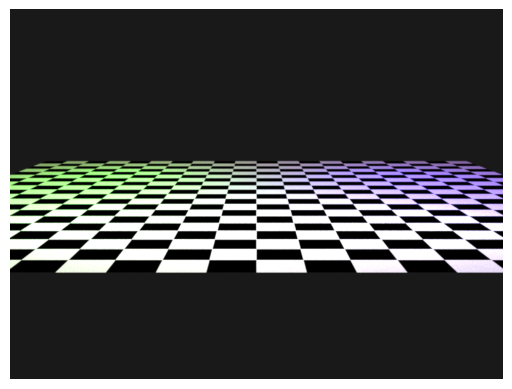

In [13]:
print("\nNo translation, same scale, rotated 90 degrees around z-axis")
e5 = update_emitters(emitters, [0, 0, 0], 1, [0, 0, 90])
render_scene(e5, config=CONFIG, save_path="output/transform5.png")

print("\nNo translation, same scale, rotated 90 degrees around x-axis")
e6 = update_emitters(emitters, [0, 0, 0], 1, [90, 0, 0])
render_scene(e6, config=CONFIG, save_path="output/transform6.png")